In [1]:
import numpy as np
from tensorflow.keras import models, layers, utils, optimizers
from tensorflow.keras.datasets import boston_housing
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
(train_data, train_target),(test_data, test_target) = boston_housing.load_data()

In [3]:
print(train_data.shape)
print(test_data.shape)
print(train_data)

(404, 13)
(102, 13)
[[1.23247e+00 0.00000e+00 8.14000e+00 ... 2.10000e+01 3.96900e+02
  1.87200e+01]
 [2.17700e-02 8.25000e+01 2.03000e+00 ... 1.47000e+01 3.95380e+02
  3.11000e+00]
 [4.89822e+00 0.00000e+00 1.81000e+01 ... 2.02000e+01 3.75520e+02
  3.26000e+00]
 ...
 [3.46600e-02 3.50000e+01 6.06000e+00 ... 1.69000e+01 3.62250e+02
  7.83000e+00]
 [2.14918e+00 0.00000e+00 1.95800e+01 ... 1.47000e+01 2.61950e+02
  1.57900e+01]
 [1.43900e-02 6.00000e+01 2.93000e+00 ... 1.56000e+01 3.76700e+02
  4.38000e+00]]


# Preparing the dataset

In [4]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data -= mean
train_data /= std
test_data -= mean
test_data /= std

In [5]:
print(train_data[0])

[-0.27224633 -0.48361547 -0.43576161 -0.25683275 -0.1652266  -0.1764426
  0.81306188  0.1166983  -0.62624905 -0.59517003  1.14850044  0.44807713
  0.8252202 ]


In [6]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizers='rmsprop', loss='mse', metrics=['mae'])
    return model

In [9]:
k = 4
num_val_samples = len(train_data) // 4
num_epochs = 100
all_score = []
all_mae_history = []
for i in range(k):
    print('processing fold# ',i)
    val_data = train_data[i * num_val_samples: (i +1) * num_val_samples]
    val_target =  train_target[i * num_val_samples: (i +1) * num_val_samples]
    partial_train_data = np.concatenate([train_data[:i*num_val_samples],train_data[(i+1)*num_val_samples:]])
    partial_train_target = np.concatenate([train_target[:i*num_val_samples],train_target[(i+1)*num_val_samples:]])
    model = build_model()
    history = model.fit(partial_train_data, partial_train_target, epochs=num_epochs, batch_size =1 , verbose = 0)
    val_mse, val_mae = model.evaluate(val_data, val_target, verbose =0)
    all_score.append(val_mae)
    mae_history = history.history['mae']
    all_mae_history.append(mae_history)

processing fold#  0
processing fold#  1
processing fold#  2
processing fold#  3


In [17]:
average_mae_history = [np.mean([x[i] for x in all_mae_history]) for i in range(num_epochs)]
print('Alll Fold Validation Error',all_score)
print('mean of all fold validation Errors', np.mean(all_score))
print('Average_mae_history', average_mae_history)

Alll Fold Validation Error [1.9707377, 2.27005, 2.5257204, 2.4923954]
mean of all fold validation Errors 2.3147259
Average_mae_history [10.580332, 3.681764, 3.0822375, 2.7441673, 2.5684109, 2.4325576, 2.377962, 2.3187633, 2.2559912, 2.203681, 2.1775346, 2.1769953, 2.1147077, 2.0973485, 2.0592089, 2.0653138, 2.0138924, 2.0171053, 1.9759635, 1.9437455, 1.9360611, 1.9122279, 1.9010432, 1.8828739, 1.8353593, 1.856806, 1.8281434, 1.8195565, 1.8269322, 1.7978483, 1.8298963, 1.7685802, 1.7678937, 1.7650765, 1.7315102, 1.7423865, 1.7282981, 1.7377832, 1.7120525, 1.6919737, 1.667796, 1.6877253, 1.6637571, 1.6477175, 1.6508714, 1.6220495, 1.6358981, 1.628492, 1.5849931, 1.601235, 1.5823172, 1.562821, 1.6094477, 1.5992248, 1.5690997, 1.5334313, 1.5479836, 1.524564, 1.5486759, 1.5392684, 1.5169369, 1.5092483, 1.4844203, 1.455578, 1.4938958, 1.4530236, 1.4382191, 1.4531436, 1.4229003, 1.4135904, 1.4421144, 1.4500701, 1.4114043, 1.4000818, 1.4290019, 1.4135163, 1.3844168, 1.4133836, 1.3752527, 1.352

In [18]:
[len(x) for x in all_mae_history]

[100, 100, 100, 100]

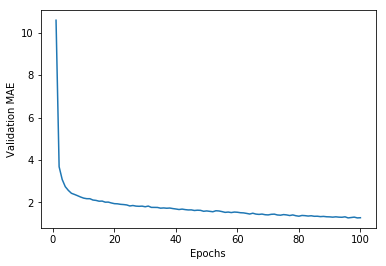

In [19]:
plt.plot(range(1, len(average_mae_history)+1),average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

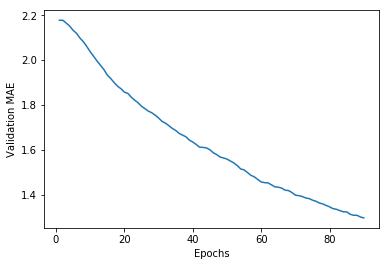

In [22]:
def smooth_curve(points, factor = 0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 -factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history)+1),smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


# Training And Validation Final Model on Complete Dataset

In [23]:
model = build_model()
history = model.fit(train_data, train_target, epochs=80, batch_size = 16 , verbose = 0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_target)
print(test_mae_score)

102/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================